# Access data from ASReview file

<div class="alert alert-warning">

The API is still under development and can change at any time without warning. 

</div>

Data generated using ASReview LAB is stored in an ASReview project file. Via the ASReview Python API, there are two ways to access the data in the ASReview (extension `.asreview`) file: Via the [project-API](generated/asreview.project.ASReviewProject.rst) and the [state-API](generated/asreview.state.rst). The project API is for retrieving general project settings, the imported dataset, the feature matrix, etc. The state API retrieves data related directly to the reviewing process, such as the labels, the time of labeling, and the classifier used. 




## Example Data
To illustrate the ASReview Python API, the benchmark dataset `van_de_Schoot_2017` is used.  The project file `example.asreview` can be obtained by running ```asreview simulate benchmark:van_de_Schoot_2017 -s example.asreview --seed 101```. 

The ASReview Python API can be used for project files obtained via the Oracle, Exploration, and Simulation mode. 

## Python Imports

In [1]:
import shutil
from pathlib import Path

import pandas as pd
from asreview import open_state
from asreview import ASReviewProject
from asreview import ASReviewData

## Project API
The ASReview project file is a zipped folder. To unzip the folder and store its contents in a temporary directory, use the following code: 

In [2]:
project_path = Path("tmp_data")
project_path.mkdir()
project = ASReviewProject.load("example.asreview", project_path)

The returned `project` instance is of type [ASReviewProject](generated/asreview.ASReviewProject.rst).

To inspect the project details, use the following code:

In [3]:
project.config

{'version': '1.0+8.gf67a5bb',
 'id': 'example',
 'mode': 'simulate',
 'name': 'example',
 'description': 'Simulation created via ASReview via command line interface',
 'authors': None,
 'created_at_unix': 1655364726,
 'datetimeCreated': '2022-06-16 09:32:06.525320',
 'reviews': [{'id': '1654e80a4cbc4bf39e1ea449581fa495',
   'start_time': '2022-06-16 09:32:06.807452',
   'status': 'finished',
   'end_time': '2022-06-16 09:32:14.092992'}],
 'feature_matrices': [{'id': 'tfidf', 'filename': 'tfidf_feature_matrix.npz'}],
 'dataset_path': 'van_de_Schoot_2017.csv'}

The imported dataset is located at `/tmp_data/{project_name}/data/{dataset_filename}`, and can be inspected using the following code: 

In [4]:
dataset_fp = Path(
    project_path, project.config["id"], "data", project.config["dataset_path"]
)
dataset = ASReviewData.from_file(dataset_fp)
print(f"The dataset contains {len(dataset)} records.")
dataset.to_dataframe().head()

The dataset contains 6189 records.


,title,abstract,keywords,authors,year,date,doi,label_included,label_abstract_screening,duplicate_record_id
record_id,,,,,,,,,,
0,Manual for ASEBA School-Age Forms & Profiles,,,"Achenbach, T. M., Rescorla, L. A.",2001.0,2001,NaN,0,0,NaN
1,Queensland Trauma Registry: A summary of paedi...,,,"Dallow, N., Lang, J., Bellamy, N.",2007.0,2007,NaN,0,0,NaN
2,Posttraumatic Stress Disorder: Scientific and ...,This comprehensive overview of research and cl...,,"Ford, J. D., Grasso, D. J., Elhai, J. D., Cour...",2015.0,NaN,NaN,0,0,NaN
3,SOCIAL CLASS AND MENTAL ILLNESS,,,"Hollingshead, A. B., Redlich, F. C.",1958.0,NaN,NaN,0,0,NaN
4,Computerised test generation for cross-nationa...,“‘Computerised Test Generation for Cross-Natio...,,"Irvine, S. H.",2014.0,NaN,NaN,0,0,NaN


To obtain the content of the feature matrix, for example, the first row of the matrix, use the following code (note the matrix is in a sparse matrix format):

In [5]:
feature_extraction_id = project.feature_matrices[0]["id"]
feature_matrix = project.get_feature_matrix(feature_extraction_id)
print(feature_matrix[0])

  (0, 20452)	0.35937211648312967
  (0, 18297)	0.26158369118434677
  (0, 13842)	0.3248271421716685
  (0, 9739)	0.38355660008860293
  (0, 3231)	0.7059309068495663
  (0, 2384)	0.22684547910949254


## State API

The data stored during the review process can be accessed as a pandas DataFrame using the following code:

In [6]:
with open_state("example.asreview") as state:
    df = state.get_dataset()
    print(f"The state contains {len(df)} records.")

The state contains 566 records.


The returned `state` instance is of type [SQLiteState](generated/asreview.state.SQLiteState.rst). Note that the state contains less records than the original dataset. This is because by default the simulation stops after finding all relevant records.

In [7]:
df.to_csv(project_path / "example_state.csv", index=False)
df.head()

,record_id,label,classifier,query_strategy,balance_strategy,feature_extraction,training_set,labeling_time,notes
0,4104,1,None,prior,None,None,-1,2022-06-16 09:32:08.461195,None
1,457,0,None,prior,None,None,-1,2022-06-16 09:32:08.461195,None
2,3704,0,nb,max,double,tfidf,2,2022-06-16 09:32:08.553967,None
3,2692,0,nb,max,double,tfidf,3,2022-06-16 09:32:08.568225,None
4,711,0,nb,max,double,tfidf,4,2022-06-16 09:32:08.578838,None


You can merge the information from the state file with the original dataset.

In [8]:
df["labeling_order"] = df.index
dataset_with_results = dataset.df.join(df.set_index("record_id"))
dataset_with_results.to_csv(project_path / "data_and_state_merged.csv", index=False)
dataset_with_results

,title,abstract,keywords,authors,year,date,doi,label_included,label_abstract_screening,duplicate_record_id,label,classifier,query_strategy,balance_strategy,feature_extraction,training_set,labeling_time,notes,labeling_order
record_id,,,,,,,,,,,,,,,,,,,
0,Manual for ASEBA School-Age Forms & Profiles,,,"Achenbach, T. M., Rescorla, L. A.",2001.0,2001,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Queensland Trauma Registry: A summary of paedi...,,,"Dallow, N., Lang, J., Bellamy, N.",2007.0,2007,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Posttraumatic Stress Disorder: Scientific and ...,This comprehensive overview of research and cl...,,"Ford, J. D., Grasso, D. J., Elhai, J. D., Cour...",2015.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SOCIAL CLASS AND MENTAL ILLNESS,,,"Hollingshead, A. B., Redlich, F. C.",1958.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Computerised test generation for cross-nationa...,“‘Computerised Test Generation for Cross-Natio...,,"Irvine, S. H.",2014.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6184,Biological and clinical framework for posttrau...,Three decades of posttraumatic stress disorder...,,"Vermetten, E., Lanius, R. A.",2012.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6185,Dividing traffic sub-areas based on a parallel...,In order to alleviate the traffic congestion a...,"GPS trajectories, K-means, MapReduce, Traffic ...","Wang, B., Tao, L., Gao, C., Xia, D., Rong, Z.,...",2014.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6186,Quantifying resilience to enhance individualiz...,Resilience is the human ability to adapt in th...,"Adaptation, Autonomic Nervous System, Resilien...","Winslow, B., Carroll, M., Jones, D., Hannigan,...",2013.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are also multiple functions to obtain one specific variable in the data. For example, to plot the labeling times in a graph, use the following code: 

<AxesSubplot:title={'center':'Time of labeling'}>

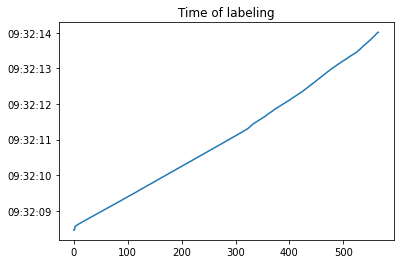

In [9]:
with open_state("example.asreview") as state:
    labeling_times = state.get_labeling_times()
pd.to_datetime(labeling_times).plot(title="Time of labeling")

By default, the records that are part of the prior knowledge are included in the results. To obtain the labels use the following code:

In [10]:
with open_state("example.asreview") as state:
    labels = state.get_labels(priors=False)
labels

0      0
1      0
2      0
3      0
4      0
      ..
559    0
560    0
561    0
562    0
563    1
Name: label, Length: 564, dtype: int64

To obtain the data corresponding to a specific record identifier, use the following code:

In [11]:
with open_state("example.asreview") as state:
    record_data = state.get_data_by_record_id(5176)
record_data

,record_id,label,classifier,query_strategy,balance_strategy,feature_extraction,training_set,labeling_time,notes
0,5176,0,nb,max,double,tfidf,63,2022-06-16 09:32:09.083643,None


To obtain all settings used for the project, run the following code:

In [12]:
with open_state("example.asreview") as state:
    settings = state.settings_metadata
settings

{'settings': {'model': 'nb',
  'query_strategy': 'max',
  'balance_strategy': 'double',
  'feature_extraction': 'tfidf',
  'n_instances': 1,
  'stop_if': 'min',
  'n_prior_included': 1,
  'n_prior_excluded': 1,
  'model_param': {'alpha': 3.822},
  'query_param': {},
  'feature_param': {'ngram_max': 1,
   'stop_words': 'english',
   'split_ta': 0,
   'use_keywords': 0},
  'balance_param': {'a': 2.155, 'alpha': 0.94, 'b': 0.789, 'beta': 1.0}},
 'state_version': '1',
 'software_version': '1.0+8.gf67a5bb',
 'model_has_trained': True}

## Cleanup
The following code removes the temporary folder that was created:

In [13]:
shutil.rmtree(project_path)